# **Stock Price Prediction using LSTMs with PyTorch** 

# Predicting Stock Prices with LSTM in PyTorch

## Introduction

This project demonstrates how to predict stock prices using **Recurrent Neural Networks (RNNs)** and **Long Short-Term Memory (LSTM)** networks in PyTorch.

### Recurrent Neural Networks (RNNs)
RNNs are designed to work with **sequential data**, leveraging information from previous steps to make predictions. By maintaining a memory of prior inputs through loops in the network, RNNs can recognize temporal patterns and relationships.  

An RNN typically consists of three types of layers:
- **Input layer** – receives the sequential data  
- **Hidden layer** – stores and processes historic information  
- **Output layer** – generates predictions  

During training, the network uses a **loss function** to measure the error between predicted and actual outputs, and weights are updated through **backpropagation**.

RNNs are especially useful for analyzing **time series data**, where previous observations influence future values.

### Long Short-Term Memory (LSTM)
Traditional RNNs often struggle with learning **long-term dependencies** due to vanishing or exploding gradients. LSTMs address this by incorporating **gates** that control the flow of information, allowing the network to retain important historical data and forget irrelevant information.  

An LSTM consists of three main gates:

1. **Forget Gate** – decides which information to discard from the cell state  
2. **Input Gate** – determines which new information to add  
3. **Output Gate** – selects the output for the next hidden state  

These gates enable the model to learn long-term dependencies more effectively, making LSTMs ideal for **time series prediction** tasks such as stock price forecasting.

### LSTM Gate Equations

**Forget Gate:**  
$$
f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)
$$

**Input Gate:**  
$$
i_t = \sigma(W_i [h_{t-1}, x_t] + b_i), \quad
\tilde{C}_t = \tanh(W_C [h_{t-1}, x_t] + b_C)
$$

**Output Gate:**  
$$
o_t = \sigma(W_o [h_{t-1}, x_t] + b_o), \quad
h_t = o_t \odot \tanh(C_t)
$$

Where:  
- $x_t$ = input at time $t$  
- $h_{t-1}$ = previous hidden state  
- $C_t$ = cell state at time $t$  
- $W$ and $b$ = weights and biases  
- $\sigma$ = sigmoid function  
- $\tanh$ = hyperbolic tangent function  
- $\odot$ = element-wise multiplication

*Reference: S. Hochreiter and J. Schmidhuber, "Long Short-Term Memory," Neural Computation, vol. 9, no. 8, pp. 1735-1780, 1997.*


## Step-1: Importing Required Libraries

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

## Step-2: Download and Load the Dataset

The stock market can be extremely volatile, there are many factors that can influence and contribute to a stock's value. This tutorial uses the following parameters for the stock data.

- **Open**: The stock's price when the market opens.
- **High**: The highest price at which a stock is trading during market hours.
- **Low**: The lowest price at which a stock is trading during market hours.
- **Close**: The stock's price when the market closes. This price is used by financial institutions as the value of a stock on a particular day because it takes into consideration all of the day's events and any fluctuations that might have occurred during the market.

The overall importance of the Close value and its use as a benchmark for a stock's daily value indicates that this value is the one to use in the prediction. To accomplish this, you can build a model that uses Long Short-Term Memory (LSTM), an RNN technique, to store and analyze large sets of time series data.


In [2]:
# Download the Dataset

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=10r0fuFBhhqcMqGg7gltBznEEdRrLznod' -O StockData.csv

--2025-09-20 23:45:33--  https://drive.google.com/uc?export=download&id=10r0fuFBhhqcMqGg7gltBznEEdRrLznod
Resolving drive.google.com (drive.google.com)... 2404:6800:4007:836::200e, 142.250.77.110
Connecting to drive.google.com (drive.google.com)|2404:6800:4007:836::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=10r0fuFBhhqcMqGg7gltBznEEdRrLznod&export=download [following]
--2025-09-20 23:45:33--  https://drive.usercontent.google.com/download?id=10r0fuFBhhqcMqGg7gltBznEEdRrLznod&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4007:816::2001, 142.250.193.161
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4007:816::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385926 (377K) [application/octet-stream]
Saving to: ‘StockData.csv’

StockData.csv       100%[===================>] 376.88K

In [3]:
# Load the Dataset

df = pd.read_csv("StockData.csv")
df.drop(['Unnamed: 0'], axis=1, inplace = True)

In [4]:
# Previewing the Dataset

df.head()

,Date,Open,High,Low,Close
0,2018-03-27,173.68,175.15,166.92,168.340
1,2018-03-26,168.07,173.10,166.44,172.770
2,2018-03-23,168.39,169.92,164.94,164.940
3,2018-03-22,170.00,172.68,168.60,168.845
4,2018-03-21,175.04,175.09,171.26,171.270


### Converting Dates and Inspecting the Dataset

- We create a new variable `stock_data` as a copy of `df` to work with, keeping the original DataFrame intact.  
- The `'Date'` column is converted to a **datetime object** using `pd.to_datetime()`, which allows for proper **time series operations and indexing**.  
- `stock_data.info()` provides a **summary of the DataFrame**, including:
  - Number of entries (rows)  
  - Column names and data types  
  - Number of non-null values  
- This step helps verify that the date conversion worked and check for any **missing data** in the dataset.


In [5]:
stock_data = df
# Convert the date column into a Datetime object:
stock_data['Date'] = pd.to_datetime(df.Date)
print("Information about the dataset", end = "\n")
print(stock_data.info())

Information about the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9400 non-null   datetime64[ns]
 1   Open    9400 non-null   float64       
 2   High    9400 non-null   float64       
 3   Low     9400 non-null   float64       
 4   Close   9400 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 367.3 KB
None


### Inspecting the Start and End of the Dataset

- This is useful in **time series analysis** to understand the chronological order of data and verify that there are no missing or misaligned entries at the start or end.


In [6]:
print("First five elements in the dataset", end = "\n")
print(stock_data.head(5))
print("Last five elements in the dataset", end = "\n")
print(stock_data.tail(5))

First five elements in the dataset
        Date    Open    High     Low    Close
0 2018-03-27  173.68  175.15  166.92  168.340
1 2018-03-26  168.07  173.10  166.44  172.770
2 2018-03-23  168.39  169.92  164.94  164.940
3 2018-03-22  170.00  172.68  168.60  168.845
4 2018-03-21  175.04  175.09  171.26  171.270
Last five elements in the dataset
           Date   Open   High    Low  Close
9395 1980-12-18  26.63  26.75  26.63  26.63
9396 1980-12-17  25.87  26.00  25.87  25.87
9397 1980-12-16  25.37  25.37  25.25  25.25
9398 1980-12-15  27.38  27.38  27.25  27.25
9399 1980-12-12  28.75  28.87  28.75  28.75


### Sorting the Dataset by Date

- `stock_data.sort_values(by="Date")` sorts the DataFrame in **chronological order** based on the `'Date'` column.  
- Sorting ensures that all **time series operations and predictions** use data in the correct temporal sequence.  
- `stock_data.head()` is used to quickly **verify that the earliest dates appear first** after sorting.

In [7]:
stock_data = stock_data.sort_values(by="Date")
print(stock_data.head())

           Date   Open   High    Low  Close
9399 1980-12-12  28.75  28.87  28.75  28.75
9398 1980-12-15  27.38  27.38  27.25  27.25
9397 1980-12-16  25.37  25.37  25.25  25.25
9396 1980-12-17  25.87  26.00  25.87  25.87
9395 1980-12-18  26.63  26.75  26.63  26.63


## Step-3: Data Scaling

### Selecting Price Features

- We select the relevant columns for modeling: `'High'`, `'Low'`, `'Open'`, and `'Close'` and store them in a new DataFrame called `price`.  
- These columns represent the **daily stock prices** that will be used as input features for the LSTM model.  


In [8]:
from sklearn.preprocessing import MinMaxScaler
price = stock_data[['High','Low','Open','Close']]
print(price[:5])

       High    Low   Open  Close
9399  28.87  28.75  28.75  28.75
9398  27.38  27.25  27.38  27.25
9397  25.37  25.25  25.37  25.25
9396  26.00  25.87  25.87  25.87
9395  26.75  26.63  26.63  26.63


### Scaling the Price Data

- We use `MinMaxScaler` from `sklearn.preprocessing` to **normalize the stock prices**.  
- `feature_range=(-1, 1)` scales all values to lie between **-1 and 1**, which helps the LSTM model **train faster and converge better**.  
- `scaler.fit_transform(price.values)` fits the scaler to the data and transforms it in one step.  

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = scaler.fit_transform(price.values)
print(price[:5])

[[-0.94884358 -0.94844388 -0.94899391 -0.94863261]
 [-0.95313783 -0.95280073 -0.95295751 -0.95297352]
 [-0.95893076 -0.95860987 -0.95877273 -0.95876139]
 [-0.95711507 -0.95680904 -0.95732616 -0.95696715]
 [-0.95495353 -0.95460157 -0.95512737 -0.95476776]]


## Step-4: Defining Training and Test Data

### Creating Input-Output Sequences for LSTM

- **Objective:** LSTMs require sequential input, so we create **sliding windows of past prices** to predict the next closing price.

1. **Define window size:**  
   `train_window = 7` means we use the **past 7 days of prices** to predict the next day's closing price.

2. **Function `create_in_out_sequences(price, tw)`:**  
   - Iterates over the entire dataset and extracts sequences of length `tw` (`data_seq`).  
   - The **label** for each sequence is the **closing price** on the day after the sequence (`data_label = price[i+tw][3]`).  
   - Appends each `(sequence, label)` pair to `inout_seq`.

3. **Train-test split:**  
   - `test_set_size = 20` defines the number of sequences to reserve for testing.  
   - `train_set_size = len(data) - test_set_size` determines the training set length.  
   - The dataset is split into `train` and `test` sequences.  
   - `train = train[:-(tw-1)]` ensures alignment so all sequences have full context.

This prepares the dataset in the **sequence format required for LSTM training**.

In [12]:
train_window = 7

# def create_in_out_sequences(price, tw):
#     inout_seq = []
#     L = len(price)
#     print('Length = ', L)
    
#     for i in range(L-tw):
#         data_seq = price.iloc[i:i+tw]  # Use .iloc for positional indexing
#         # Option 1: Access by column name (recommended)
#         data_label = price.iloc[i+tw]['Close']  # assuming 'Close' column exists
        
#         # Option 2: Access by position (if Close is the 4th column, index 3)
#         # data_label = price.iloc[i+tw, 3]
#         inout_seq.append((data_seq, data_label))
    
#     data = inout_seq
#     print('size of data : ', len(data))
    
#     test_set_size = 20
#     train_set_size = len(data) - test_set_size
#     print('size of test : ', test_set_size)
#     print('size of train : ', train_set_size)
    
#     train = data[:train_set_size]
#     test = data[train_set_size:]
#     train = train[:-(tw-1)]
#     return train, test

# train, test = create_in_out_sequences(price, train_window)

def create_in_out_sequences(price, tw):
    inout_seq = []
    L = len(price)
    print('Length = ', L)
    
    for i in range(L-tw):
        data_seq = price[i:i+tw]
        data_label = price[i+tw:i+tw+1][0][3]
        inout_seq.append((data_seq ,data_label))
    
    data = inout_seq;
    print('size of data : ', len(data))
    
    test_set_size = 20
    train_set_size = len(data) - (test_set_size);
    print('size of test : ', test_set_size)
    print('size of train : ', train_set_size)
    
    train = data[:train_set_size]
    test = data[train_set_size:]
    train = train[:-(tw-1)]
    return train, test
    
train,test = create_in_out_sequences(price, train_window)

Length =  9400
size of data :  9393
size of test :  20
size of train :  9373


The `create_in_out_sequences` method creates labels for the dataset and isolates the datapoints we are inputting into the model, taking into account the training and test size and returns the training and test sets.


In [13]:
print(test[0])
print(train[-1])

(array([[-0.52820808, -0.53303223, -0.53350981, -0.53283172],
       [-0.52982203, -0.53404883, -0.53440669, -0.5345102 ],
       [-0.53022552, -0.5352397 , -0.53215004, -0.53676747],
       [-0.53071547, -0.5332065 , -0.53512997, -0.53233975],
       [-0.52581598, -0.52789114, -0.5297198 , -0.52378816],
       [-0.51503711, -0.52013593, -0.52196618, -0.51390537],
       [-0.51189567, -0.51447202, -0.51401004, -0.51558385]]), np.float64(-0.5163652148748373))
(array([[-0.56112112, -0.56992463, -0.56034371, -0.57013457],
       [-0.56803804, -0.58165473, -0.56843004, -0.58234698],
       [-0.57700122, -0.59556763, -0.57774595, -0.58046592],
       [-0.55970891, -0.5744514 , -0.57360876, -0.56096079],
       [-0.55723035, -0.56242648, -0.56362742, -0.55624367],
       [-0.54918942, -0.55885386, -0.56045943, -0.54747504],
       [-0.53319403, -0.54107789, -0.54094519, -0.53121111]]), np.float64(-0.5328317175517292))


## Step-5: Defining LSTM and forward method

- We define a **custom LSTM model** using PyTorch by subclassing `nn.Module`.

#### Model Components:

1. **Initialization (`__init__`)**  
   - `input_size=4`: Each input has 4 features (`High`, `Low`, `Open`, `Close`).  
   - `hidden_layer_size=100`: Number of neurons in the LSTM hidden layer.  
   - `output_size=1`: Predicting a single value — the **next day’s closing price**.  
   - `self.lstm = nn.LSTM(input_size, hidden_layer_size)`: LSTM layer to process sequential data.  
   - `self.linear = nn.Linear(hidden_layer_size, output_size)`: Fully connected layer to map LSTM output to the predicted price.

2. **Forward Pass (`forward`)**  
   - `hidden_cell`: Initializes the **hidden state and cell state** to zeros.  
   - `input_seq.view(len(input_seq), 1, -1)`: Reshapes input to match LSTM expected shape `(sequence_length, batch_size, features)`.  
   - `lstm_out, hidden_cell = self.lstm(...)`: Processes the input sequence through the LSTM.  
   - `lstm_out.view(len(input_seq), -1)`: Reshapes LSTM output for the linear layer.  
   - `self.linear(...)`: Converts hidden layer output to a single prediction.  
   - `return predictions[-1]`: Returns the **last output** of the sequence as the predicted closing price.

- **Summary:** This model takes a **sequence of past 7 days** (or `train_window`) of stock prices and predicts the **next day’s closing price** using an LSTM with a fully connected output layer.

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                       torch.zeros(1,1,self.hidden_layer_size),
                      )
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

### Initializing the LSTM Model, Loss Function, and Optimizer

- **Loss Funstion** :  Mean Squared Error (MSE) is used to measure the difference between predicted and actual closing prices. It's a standard choice for regression tasks.
- **Optimiser** : Adam optimizer is used to update the model's weights during training.
   - lr=0.001 specifies the learning rate, controlling the size of each weight update step.

Together, these components set up the model for training: the LSTM generates predictions, the loss function quantifies the error, and the optimizer adjusts the weights to minimize that error.

In [15]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Step-6: Model Training

### Training the LSTM Model

This loop is responsible for training the LSTM model to predict the next day's closing price based on sequences of past stock prices. The process works as follows:

1. **Epoch Loop:** The training process runs for multiple epochs (iterations over the entire training dataset) to allow the model to gradually learn patterns from the data.

2. **Sequence Iteration:** For each epoch, the model iterates over every input sequence and its corresponding label in the training set.

3. **Data Preparation:** Each sequence and label is converted into a PyTorch tensor of type `FloatTensor` so it can be processed by the model.

4. **Resetting Gradients:** Before each forward pass, the optimizer's gradients are reset to avoid accumulation from previous steps.

5. **Forward Pass:** The model processes the input sequence and predicts the next day's closing price.

6. **Reshaping Labels:** The label tensor is reshaped to ensure it matches the prediction's shape for correct loss calculation.

7. **Loss Calculation:** The difference between the predicted value and the actual closing price is measured using Mean Squared Error (MSE), which quantifies the prediction error.

8. **Backward Pass and Optimization:** The loss is backpropagated through the network, and the optimizer updates the model's weights to reduce the error.

9. **Tracking Epoch Loss:** The loss for each sequence is accumulated to calculate the average loss for the epoch, which provides insight into how well the model is learning.

10. **Monitoring Training Progress:** After each epoch, the average loss is printed. A decreasing loss over epochs indicates that the model is successfully learning the patterns in the stock price data.

Overall, this loop trains the LSTM iteratively, enabling it to capture temporal dependencies in the stock prices and improve prediction accuracy over time.


In [16]:
from tqdm import tqdm
        
epochs = 5
for i in tqdm(range(epochs)):
    epoch_loss = 0
    for seq, labels in tqdm(train):
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()

        y_pred = model(seq)
        
        labels = labels.view(1)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    average_loss = epoch_loss / len(train)
    print(f'epoch: {i:3} loss: {average_loss:.10f}')

 20%|██        | 1/5 [00:21<01:27, 21.98s/it]

epoch:   0 loss: 0.0021388491


 40%|████      | 2/5 [00:44<01:06, 22.04s/it]

epoch:   1 loss: 0.0012496319


 60%|██████    | 3/5 [01:06<00:44, 22.03s/it]

epoch:   2 loss: 0.0011904166


 80%|████████  | 4/5 [01:27<00:21, 21.67s/it]

epoch:   3 loss: 0.0011462343


100%|██████████| 5/5 [01:48<00:00, 21.69s/it]

epoch:   4 loss: 0.0009721060


### Evaluating the LSTM Model on Test Data

- **Switch to Evaluation Mode:** The model is set to evaluation mode, which **disables dropout and other training-specific behaviors**, ensuring consistent predictions.  

- **Prepare Lists for Results:** Two empty lists are initialized: one for the **actual closing prices** and one for the **predicted closing prices**.  

- **Iterate Over Test Sequences:** For each sequence in the test set:
  - Convert the sequence and its label into PyTorch tensors.
  - Append the actual closing price to the `actual` list.
  - Use `torch.no_grad()` to **disable gradient computation** during prediction, which saves memory and speeds up evaluation.
  - Pass the input sequence to the model and append the predicted closing price to the `pred` list.

- **Convert to NumPy Arrays:** After iterating through all test sequences, both `actual` and `pred` lists are converted into NumPy arrays.  

This process generates the **predicted vs actual stock prices**, which can be used for **visualization, error calculation, or further analysis** to evaluate the model’s performance on unseen data.


In [17]:
model.eval()
actual = []
pred = []

for seq, labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        pred.append(model(seq).item())

actual = np.array(actual)
pred = np.array(pred)

### Converting Predictions and Actual Values to Tensors

- The predicted (`pred`) and actual (`actual`) stock prices, which were stored as NumPy arrays, are converted into **PyTorch tensors**.  
- This conversion is necessary if we want to perform **further tensor-based operations** in PyTorch, such as calculating metrics, loss, or performing batch operations.  
- Using tensors allows leveraging **GPU acceleration** and PyTorch’s built-in functions for efficient computation.


In [18]:
pred = torch.from_numpy(np.array(pred)).type(torch.Tensor)
actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)

In [19]:
print(pred)
print(actual)

tensor([-0.5447, -0.5448, -0.5487, -0.5502, -0.5475, -0.5467, -0.5501, -0.5473,
        -0.5443, -0.5417, -0.5423, -0.5450, -0.5447, -0.5457, -0.5490, -0.5485,
        -0.5525, -0.5557, -0.5593, -0.5535])
tensor([-0.5164, -0.5254, -0.5219, -0.5201, -0.5206, -0.5253, -0.5198, -0.5110,
        -0.5059, -0.5110, -0.5154, -0.5148, -0.5167, -0.5245, -0.5247, -0.5362,
        -0.5432, -0.5545, -0.5318, -0.5447])


### Inverting the Scaling of Predictions

- The LSTM model was trained on **scaled stock prices** (values between -1 and 1), so the predictions are also in the scaled range.  
- To interpret predictions in the **original price scale**, we apply the inverse transform using the same `MinMaxScaler` that was used for scaling.  
- Since `MinMaxScaler` expects all feature columns, we create a temporary array with zeros for the other columns and insert the predicted closing prices in the fourth column.  
- `scaler.inverse_transform()` converts the scaled predictions back to **actual stock price values**.  
- `pred_new[:,3]` extracts the **predicted closing prices** in their original scale, which can now be compared directly to the true closing prices.


In [20]:
pred_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(pred)])
print(pred_new[:,3])

[168.32746409 168.28056612 166.9549004  166.44188564 167.37030889
 167.62728998 166.46019583 167.44383798 168.47308053 169.3820402
 169.1569629  168.22017752 168.32540445 167.98467846 166.82674969
 167.02146792 165.62688669 164.51935728 163.28538666 165.29063011]


/tmp/ipykernel_255659/692812478.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pred_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(pred)])


### Inverting the Scaling of Actual Values

- Just like the predictions, the **actual closing prices** in the test set were originally scaled between -1 and 1.  
- To compare predictions with real prices in a meaningful way, we **invert the scaling** using the same `MinMaxScaler`.  
- We create a temporary array with zeros for the other features and place the actual closing prices in the fourth column.  
- `scaler.inverse_transform()` converts the scaled values back to their **original price range**.  
- `actual_new[:,3]` extracts the **true closing prices** in their original scale, ready for comparison with the predicted prices.


In [21]:
actual_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(actual)])
print(actual_new[:,3])

[178.11999474 174.99999256 176.21000958 176.81999212 176.67000924
 175.03000149 176.94000725 179.97999249 181.71999569 179.97000324
 178.44000078 178.65000152 178.0199993  175.2999995  175.24000223
 171.27000783 168.84501005 164.93999725 172.77000135 168.34000729]


/tmp/ipykernel_255659/1021062276.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  actual_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(actual)])


## Step-7 : Model Evaluation

### Evaluating Model Performance

- After obtaining the predicted and actual closing prices in their **original scale**, we calculate **error metrics** to measure the model's accuracy.

1. **Mean Absolute Error (MAE):**  
   - Represents the **average absolute difference** between predicted and actual prices.  
   - Lower MAE indicates that predictions are closer to the true values.

2. **Root Mean Squared Error (RMSE):**  
   - Measures the **square root of the average squared differences** between predicted and actual prices.  
   - RMSE penalizes larger errors more heavily than MAE.  
   - Lower RMSE indicates better model performance.

- These metrics provide a quantitative assessment of the LSTM model's **accuracy in predicting stock prices**.


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_new, pred_new)
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mean_squared_error(actual_new, pred_new))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 2.0656969268620027
Root Mean Squared Error (RMSE): 4.431896161323


### Visualizing Predicted vs Actual Stock Prices

- A line plot is created to **compare the model's predictions with the actual stock prices**.  

- **Red line (`Actual`)**: Represents the true closing prices from the test set.  
- **Cyan line (`Predicted`)**: Represents the closing prices predicted by the LSTM model.  


**Interpretation:** The closer the predicted line follows the actual line, the better the model is at capturing the stock price trends. This visual comparison provides an intuitive sense of model performance beyond numerical metrics.


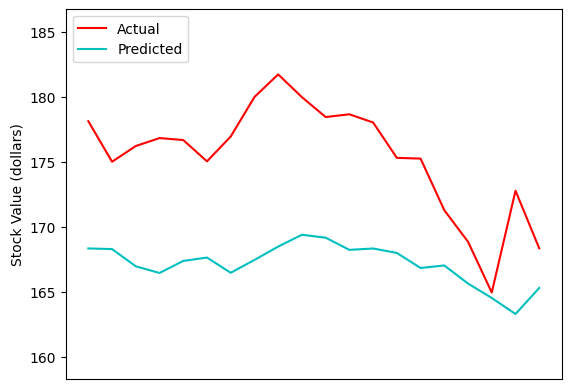

In [24]:
fig, ax = plt.subplots()

ax.plot(actual_new[:,3], 'r-', label='Actual')
ax.plot(pred_new[:,3], 'c-', label='Predicted')

ax.set_ylabel('Stock Value (dollars)')

ax.set_ylim(min(min(actual_new[:,3]), min(pred_new[:,3])) - 5, max(max(actual_new[:,3]), max(pred_new[:,3])) + 5)
plt.xticks([])

ax.legend(loc='upper left')

plt.show()

### Visualizing Prediction Errors

- We calculate the **difference** between actual and predicted stock prices to see how far off the model is for each time step.  

- A line plot is created with the differences:
  - **Blue line** shows the error for each prediction.

- **Interpretation:** This visualization highlights where the model **overestimates or underestimates** the stock price and helps identify patterns in prediction errors over time.  
- Large spikes indicate periods where the model struggled to predict accurately, while values near zero indicate accurate predictions.


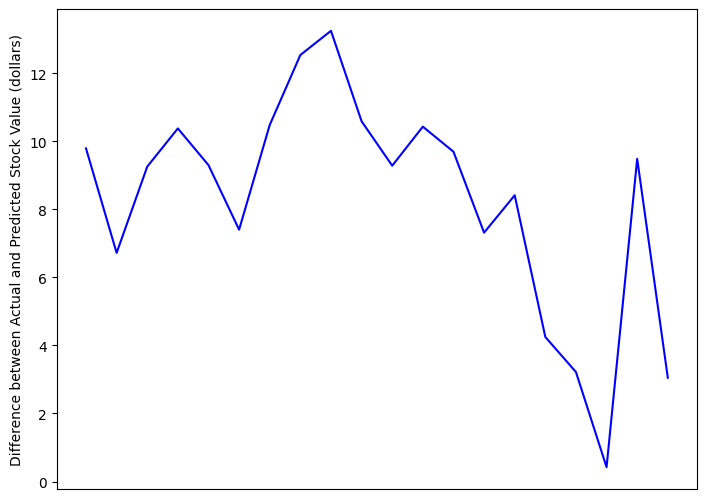

In [25]:
difference = actual_new - pred_new
fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:, 3], 'b')
diffGraph.set_ylabel('Difference between Actual and Predicted Stock Value (dollars)')
plt.xticks([])
plt.show()

## Step-8 Model Testing

In [33]:
# Download the Test Dataset - goldstock.csv

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=11NAOQIrlVZbaWzGTOIkEaqVxd313U20R' -O goldstock.csv

--2025-09-20 23:58:23--  https://drive.google.com/uc?export=download&id=11NAOQIrlVZbaWzGTOIkEaqVxd313U20R
Resolving drive.google.com (drive.google.com)... 2404:6800:4002:803::200e, 172.217.167.206
Connecting to drive.google.com (drive.google.com)|2404:6800:4002:803::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=11NAOQIrlVZbaWzGTOIkEaqVxd313U20R&export=download [following]
--2025-09-20 23:58:24--  https://drive.usercontent.google.com/download?id=11NAOQIrlVZbaWzGTOIkEaqVxd313U20R&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2404:6800:4002:805::2001, 142.250.67.65
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2404:6800:4002:805::2001|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133916 (131K) [application/octet-stream]
Saving to: ‘goldstock.csv’

goldstock.csv       100%[===================>] 130.78K 

### Testing the LSTM Model on a New Dataset (Gold Prices)
 
- The dataset is **sorted by date** to maintain chronological order, which is essential for time series prediction.  
- Relevant columns for modeling (`Close`, `Open`, `High`, `Low`) are selected and stored in `gold_price`.  
- Since the LSTM model was trained on **scaled stock prices**, we apply the **same MinMaxScaler** to normalize the gold price data.  
- This ensures that the new data is on the **same scale** as the training data, allowing the model to make meaningful predictions on unseen datasets.


In [34]:
df = pd.read_csv('goldstock.csv')
df = df.sort_values(by="Date")
gold_price = df[['Close', 'Open', 'High', 'Low']]
gold_price = scaler.fit_transform(gold_price.values)

### Creating Input-Output Sequences for Gold Price Prediction

- To prepare the gold price data for the LSTM, we use the same **sequence-based approach** as for the stock data.  
- `train_window = 7` specifies that each input sequence consists of **7 consecutive days of price data**.  
- `create_in_out_sequences` generates:
  - `gold_train`: sequences for training the model (if retraining is needed)  
  - `gold_test`: sequences for evaluating the model on the gold price data  
- This step converts the time series into the **format required by the LSTM**, where each sequence is paired with the next day's closing price as the label.


In [35]:
train_window = 7 
gold_train, gold_test = create_in_out_sequences(gold_price, train_window)

Length =  2511
size of data :  2504
size of test :  20
size of train :  2484


### Training the LSTM Model on Stock Data (or Retraining if Needed)

- The model is trained over multiple epochs to **learn temporal patterns** in the input sequences.  

- **Epoch Loop:** Iterates over the dataset several times to improve learning.  

- **Sequence Loop:** Processes each input sequence and its corresponding label.  

- **Data Conversion:** Sequences and labels are converted to PyTorch tensors to be compatible with the LSTM model.  

- **Forward Pass:** The model predicts the next day's closing price for each sequence.  

- **Loss Calculation:** The difference between predicted and actual prices is measured using Mean Squared Error (MSE).  

- **Backward Pass and Optimization:** Gradients are computed and the model's weights are updated to minimize the loss.  

- **Epoch Loss Tracking:** Losses from all sequences are accumulated, and the **average loss per epoch** is printed to monitor model performance.  

> This iterative process allows the LSTM to gradually improve its predictions by adjusting weights according to the observed errors.


In [36]:
epochs = 5
for i in tqdm(range(epochs)):
    epoch_loss = 0
    for seq, labels in tqdm(train):
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()

        y_pred = model(seq)
        
        labels = labels.view(1)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    average_loss = epoch_loss / len(train)
    print(f'epoch: {i:3} loss: {average_loss:.10f}')

 20%|██        | 1/5 [00:16<01:04, 16.15s/it]

epoch:   0 loss: 0.0008625218


 40%|████      | 2/5 [00:31<00:47, 15.76s/it]

epoch:   1 loss: 0.0007922779


 60%|██████    | 3/5 [00:47<00:31, 15.74s/it]

epoch:   2 loss: 0.0007317561


 80%|████████  | 4/5 [01:03<00:15, 15.76s/it]

epoch:   3 loss: 0.0006733751


100%|██████████| 5/5 [01:18<00:00, 15.75s/it]

epoch:   4 loss: 0.0006216859


### Evaluating the LSTM Model on the Test Dataset

- The model is set to **evaluation mode**, which disables training-specific behaviors like dropout.  

- **Lists Initialization:** Two empty lists are created to store the **actual closing prices** and **predicted values**.  

- **Iteration over Test Sequences:** For each sequence in the test set:
  - Convert the sequence and label into PyTorch tensors.
  - Append the actual closing price to the `actual` list.
  - Use `torch.no_grad()` to **disable gradient calculations** during prediction, saving memory and speeding up computation.
  - Append the model’s predicted closing price to the `pred` list.

- **Conversion to NumPy Arrays:** After processing all sequences, both `actual` and `pred` are converted to NumPy arrays for further analysis, such as error calculation or visualization.

> This step generates the predicted versus actual closing prices for the test set, enabling evaluation of the model’s performance.


In [37]:
model.eval()
actual = []
pred = []

for seq, labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        pred.append(model(seq).item())

actual = np.array(actual)
pred = np.array(pred)

### Converting Predictions and Actual Values Back to Original Scale and Evaluating Performance

- **Conversion to Tensors:** The predicted (`gold_pred`) and actual (`gold_actual`) closing prices are converted into PyTorch tensors to allow further operations.  

- **Inverse Scaling:** Since the model was trained on **scaled values**, the predictions and actual prices are transformed back to the **original price range** using the same `MinMaxScaler`.  
  - A temporary array of zeros is used for other columns, and the closing prices are inserted in the fourth column before applying `inverse_transform`.  
  - `gold_pred_new` contains the **predicted gold prices**, and `gold_actual_new` contains the **actual gold prices** in their original scale.

- **Performance Metric (RMSE):**  
  - Root Mean Squared Error (RMSE) is computed to quantify how close the predicted prices are to the actual prices.  
  - Lower RMSE indicates better predictive performance.

> This process ensures that predictions can be interpreted in terms of **real-world prices** and provides a quantitative measure of the model’s accuracy on unseen gold price data.


In [38]:
gold_pred = torch.from_numpy(np.array(pred)).type(torch.Tensor)
gold_actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)

gold_pred_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(gold_pred)])
gold_actual_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(gold_actual)])

rmse = np.sqrt(mean_squared_error(gold_actual_new, gold_pred_new))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 4.851741760102917


/tmp/ipykernel_255659/2597457892.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  gold_pred_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(gold_pred)])
/tmp/ipykernel_255659/2597457892.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  gold_actual_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(gold_actual)])


### Visualizing Predicted vs Actual Gold Prices

- A line plot is created to **compare the model’s predicted gold prices with the actual closing prices**.  

- **Red line (`Actual`)**: Shows the true gold closing prices from the test set.  
- **Cyan line (`Predicted`)**: Shows the gold prices predicted by the LSTM model.  

- **Interpretation:**  
  - The closer the predicted line follows the actual line, the better the model is at capturing trends in gold prices.  
  - Deviations between the lines highlight areas where the model underestimates or overestimates the price.  
- This visualization helps in understanding the **accuracy and reliability** of the model on new, unseen data.


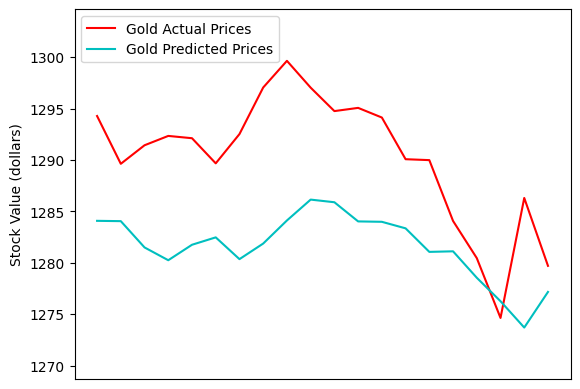

In [39]:
fig, ax = plt.subplots()

ax.plot(gold_actual_new[:,3], 'r-', label='Gold Actual Prices')
ax.plot(gold_pred_new[:,3], 'c-', label='Gold Predicted Prices')

ax.set_ylabel('Stock Value (dollars)')

ax.set_ylim(min(min(gold_actual_new[:,3]), min(gold_pred_new[:,3])) - 5, max(max(gold_actual_new[:,3]), max(gold_pred_new[:,3])) + 5)
plt.xticks([])

ax.legend(loc='upper left')

plt.show()

### Visualizing Prediction Errors for Gold Prices

- We calculate the **difference between actual and predicted gold prices** to analyze the model's prediction errors.  

- The differences highlight where the model **overestimates or underestimates** the true closing prices.  
- A line plot is created with the differences:
  - **Blue line** shows the error for each prediction.  

- **Interpretation:**  
  - Values near zero indicate accurate predictions.  
  - Large spikes indicate points where the model struggled to predict accurately.  
  - This visualization provides insight into the **consistency and reliability** of the model across the test dataset.


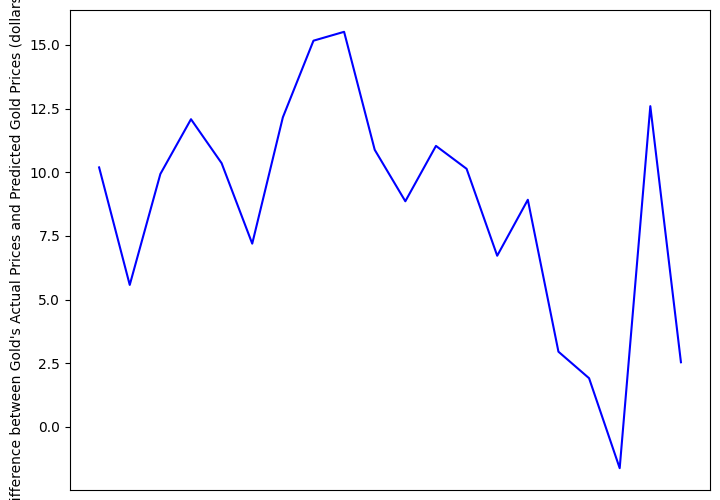

In [40]:
difference = gold_actual_new - gold_pred_new
fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:, 3], 'b')
diffGraph.set_ylabel('Difference between Gold\'s Actual Prices and Predicted Gold Prices (dollars)')
plt.xticks([])
plt.show()